<a href="https://colab.research.google.com/github/hasonsk/Polyp-U-Net/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data

In [ ]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
def load_data(path, split=0.2):
  images = sorted(glob(os.path.join(path, "image/*")))
  masks = sorted(glob(os.path.join(path, "mask/*")))

  total_size = len(images)
  print(total_size)
  valid_size = int(split * total_size)
  test_size = int(split * total_size)

  train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
  train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

  train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
  train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

  return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [ ]:
path = "/content/drive/MyDrive/Xu_ly_anh/dataset_train_880"
(train_x, train_y), (valid_x, valid_y), (test_x, test_y)= load_data(path)
print(len(train_x), len(valid_x), len(test_x))

880
528 176 176


In [ ]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    x = x.astype(np.float32) / 255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = x.astype(np.float32) / 255.0
    x = np.expand_dims(x, axis=-1)
    return x

def mask_parse(mask):
  mask = np.squeeze(mask)
  mask = [mask, mask, mask]
  mask = np.transpose(mask, (1, 2, 0))
  return mask

def tf_parse(x, y):
  def _parse(x, y):
    x = read_image(x)
    y = read_mask(y)
    return x, y

  x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
  x.set_shape([256, 256, 3])
  y.set_shape([256, 256, 1])
  return x, y

def tf_dataset(x, y, batch=8):
  dataset = tf.data.Dataset.from_tensor_slices((x, y))
  dataset = dataset.map(tf_parse)
  dataset = dataset.batch(batch)
  dataset = dataset.repeat()
  return dataset

In [ ]:
ds = tf_dataset(test_x, test_y)
for (x, y) in ds:
  print(x.shape, y.shape)
  break

(8, 256, 256, 3) (8, 256, 256, 1)


# model.py

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [ ]:
def conv_block(x, num_filters):
  x = Conv2D(num_filters, (3, 3), padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(num_filters, (3, 3), padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  return x

In [ ]:
def build_model():
  size = 256
  num_filters = [16, 32, 48, 64]
  inputs = Input((size, size, 3))

  skip_x = []
  x = inputs
  ## Encoder
  for f in num_filters:
    x = conv_block(x, f)
    skip_x.append(x)
    x = MaxPool2D((2, 2))(x)

  ## Bridge
  x = conv_block(x, num_filters[-1])

  num_filters.reverse()
  skip_x.reverse()
  ## Decoder
  for i, f in enumerate(num_filters):
    x = UpSampling2D((2, 2))(x)
    xs = skip_x[i]
    x = Concatenate()([x, xs])
    x = conv_block(x, f)

  ## Output
  x = Conv2D(1, (1, 1), padding="same")(x)
  x = Activation("sigmoid")(x)

  return Model(inputs, x)

In [ ]:
if __name__ == "__main__":
  model = build_model()
  model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

# Train.py

In [ ]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard

In [ ]:
## Hyperparameters
batch = 8
lr = 1e-4
epochs = 10

train_dataset = tf_dataset(train_x, train_y, batch=batch)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch)

model = build_model()

opt = tf.keras.optimizers.Adam(lr)
metrics = ["acc", tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=metrics)
path_checkpoint = "/content/drive/MyDrive/Xu_ly_anh/model/cp.ckpt"
directory_checkpoint = os.path.dirname(path_checkpoint)

callbacks = [
  ModelCheckpoint("/content/drive/MyDrive/Xu_ly_anh/model/model.h5"),
  ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
  CSVLogger("/content/drive/MyDrive/Xu_ly_anh/model/data.csv"),
  TensorBoard(),
  EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

train_steps = len(train_x)//batch
valid_steps = len(valid_x)//batch

if len(train_x) % batch != 0:
  train_steps += 1
if len(valid_x) % batch != 0:
  valid_steps += 1

history = model.fit(train_dataset,
  validation_data=valid_dataset,
  epochs=epochs,
  steps_per_epoch=train_steps,
  validation_steps=valid_steps,
  callbacks=callbacks)

Epoch 1/10
66/66 [==============================] - 405s 6s/step - loss: 0.6608 - acc: 0.6320 - recall_1: 0.7215 - precision_1: 0.2642 - val_loss: 0.6740 - val_acc: 0.7713 - val_recall_1: 0.2213 - val_precision_1: 0.2191 - lr: 1.0000e-04
Epoch 2/10
66/66 [==============================] - 268s 4s/step - loss: 0.5009 - acc: 0.8133 - recall_1: 0.4994 - precision_1: 0.4305 - val_loss: 0.5663 - val_acc: 0.8554 - val_recall_1: 7.2196e-05 - val_precision_1: 0.0214 - lr: 1.0000e-04
Epoch 3/10
66/66 [==============================] - 263s 4s/step - loss: 0.4568 - acc: 0.8555 - recall_1: 0.4749 - precision_1: 0.5613 - val_loss: 0.5015 - val_acc: 0.8559 - val_recall_1: 1.8049e-06 - val_precision_1: 0.0309 - lr: 1.0000e-04
Epoch 4/10
66/66 [==============================] - 263s 4s/step - loss: 0.4287 - acc: 0.8715 - recall_1: 0.4989 - precision_1: 0.6298 - val_loss: 0.4567 - val_acc: 0.8561 - val_recall_1: 0.0026 - val_precision_1: 0.6552 - lr: 1.0000e-04
Epoch 5/10
66/66 [======================

In [ ]:
model.save('/content/drive/MyDrive/Xu_ly_anh/model/model_save.h5')

<ipython-input-28-643efc3093df>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


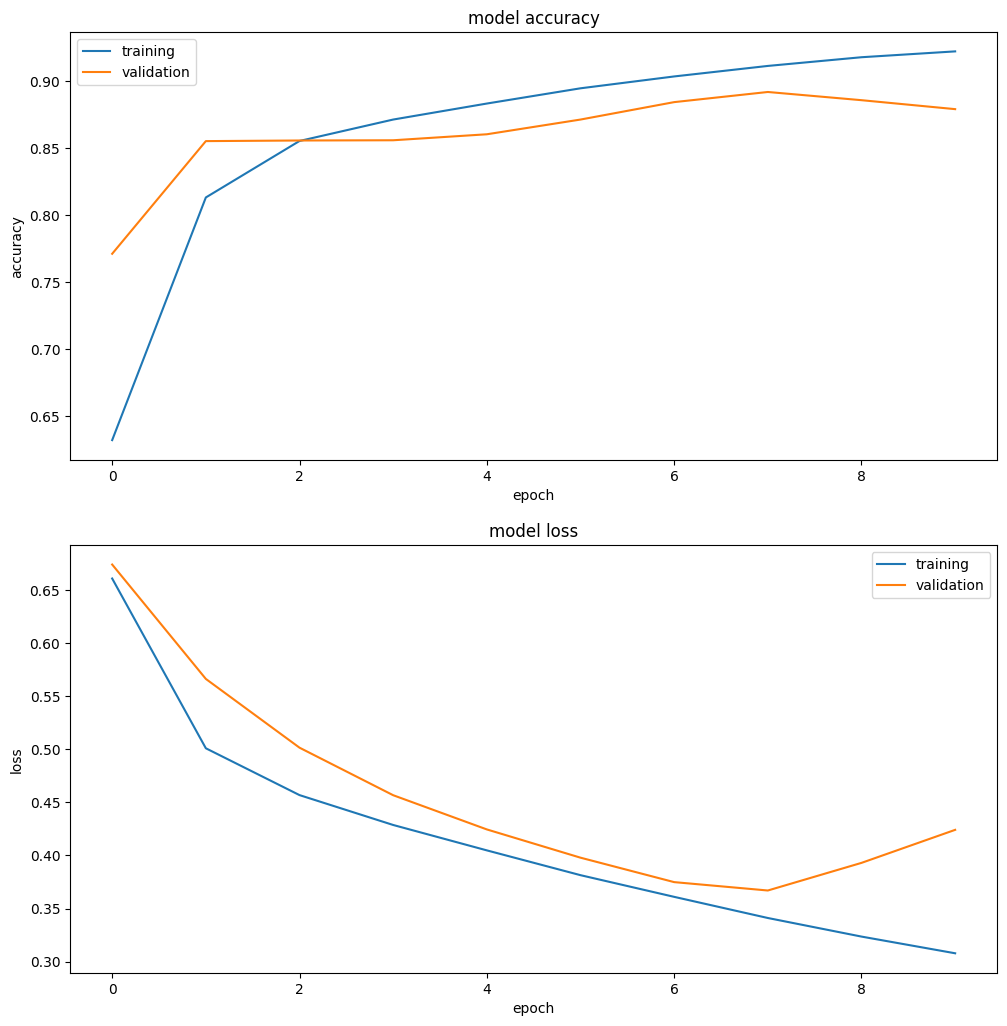

In [ ]:
import matplotlib.pyplot as plt
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['acc'], history.history['val_acc'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

# Predict.py

In [ ]:
from tensorflow.keras.utils import CustomObjectScope
from tqdm import tqdm

In [ ]:
def load_data(path, split=0.2):
  images = sorted(glob(os.path.join(path, "images/*")))
  masks = sorted(glob(os.path.join(path, "masks/*")))

  # total_size = len(images)
  # test_size = int(split * total_size)

  # train_x, valid_x = train_test_split(images, test_size=test_size, random_state=42)
  # train_y, valid_y = train_test_split(masks, test_size=test_size, random_state=42)

  # train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
  # train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

  test_x = images
  test_y = masks
  return (test_x, test_y)


path = "/content/drive/MyDrive/Kvasir_SEG_Training_880/Kvasir_SEG_Validation_120"
batch = 8

(test_x, test_y)= load_data(path)
print(len(test_x))

test_dataset = tf_dataset(test_x, test_y, batch = batch)
test_steps = len(test_x)//batch
if(len(test_x) % batch != 0):
  test_steps += 1

with CustomObjectScope():
  model = tf.keras.models.load_model("files/model.h5")
model.evaluate(test_dataset, steps=test_steps)

In [ ]:
from keras.models import load_model
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    x = x.astype(np.float32) / 255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = x.astype(np.float32) / 255.0
    x = np.expand_dims(x, axis=-1)
    return x

def mask_parse(mask):
  mask = np.squeeze(mask)
  mask = [mask, mask, mask]
  mask = np.transpose(mask, (1, 2, 0))
  return mask

In [ ]:
x = read_image('/content/drive/MyDrive/Xu_ly_anh/dataset_train_880/image/cju0qkwl35piu0993l0dewei2.png')
model = load_model('/content/drive/MyDrive/Xu_ly_anh/model/model.h5')
y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
h, w, _ = x.shape
white_line = np.ones((h, 10, 3)) * 255.0

all_images = [
  x * 255.0, white_line,
  mask_parse(y_pred) * 255.0
]
image = np.concatenate(all_images, axis=1)
cv2.imwrite("/content/drive/MyDrive/Xu_ly_anh/results/0_test_demo.png", image)

1/1 [==============================] - 0s 381ms/step


True

In [ ]:
def load_data_test(path):
  images = sorted(glob(os.path.join(path, "images/*")))
  masks = sorted(glob(os.path.join(path, "masks/*")))

  test_x = images
  test_y = masks
  return (test_x, test_y)


path = "/content/drive/MyDrive/Xu_ly_anh/Kvasir_SEG_Validation_120"
batch = 8

(test_x, test_y)= load_data_test(path)
print(len(test_x))

test_dataset = tf_dataset(test_x, test_y, batch = batch)
test_steps = len(test_x)//batch
if(len(test_x) % batch != 0):
  test_steps += 1

with CustomObjectScope():
  model = tf.keras.models.load_model("/content/drive/MyDrive/Xu_ly_anh/model/model.h5")
for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
  x = read_image(x)
  y = read_mask(y)
  y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
  h, w, _ = x.shape
  white_line = np.ones((h, 10, 3)) * 255.0

  all_images = [
    x * 255.0, white_line,
    mask_parse(y_pred) * 255.0
  ]
  image = np.concatenate(all_images, axis=1)
  cv2.imwrite(f"/content/drive/MyDrive/Xu_ly_anh/results/{i}.png", image)

120


  0%|          | 0/120 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


  1%|          | 1/120 [00:09<19:33,  9.86s/it]

1/1 [==============================] - 0s 121ms/step


  2%|▏         | 2/120 [00:10<08:13,  4.18s/it]

1/1 [==============================] - 0s 107ms/step


  2%|▎         | 3/120 [00:10<04:34,  2.35s/it]

1/1 [==============================] - 0s 122ms/step


  3%|▎         | 4/120 [00:10<02:52,  1.49s/it]

1/1 [==============================] - 0s 107ms/step


  4%|▍         | 5/120 [00:10<01:56,  1.01s/it]

1/1 [==============================] - 0s 120ms/step


  5%|▌         | 6/120 [00:10<01:23,  1.37it/s]

1/1 [==============================] - 0s 103ms/step


  6%|▌         | 7/120 [00:10<01:01,  1.84it/s]

1/1 [==============================] - 0s 104ms/step


  7%|▋         | 8/120 [00:11<00:47,  2.36it/s]

1/1 [==============================] - 0s 105ms/step


  8%|▊         | 9/120 [00:11<00:38,  2.89it/s]

1/1 [==============================] - 0s 110ms/step


  8%|▊         | 10/120 [00:11<00:32,  3.42it/s]

1/1 [==============================] - 0s 102ms/step


  9%|▉         | 11/120 [00:11<00:27,  3.96it/s]

1/1 [==============================] - 0s 102ms/step


 10%|█         | 12/120 [00:11<00:24,  4.45it/s]

1/1 [==============================] - 0s 103ms/step


 11%|█         | 13/120 [00:11<00:22,  4.84it/s]

1/1 [==============================] - 0s 103ms/step


 12%|█▏        | 14/120 [00:12<00:20,  5.08it/s]

1/1 [==============================] - 0s 99ms/step


 12%|█▎        | 15/120 [00:12<00:19,  5.41it/s]

1/1 [==============================] - 0s 111ms/step


 13%|█▎        | 16/120 [00:12<00:18,  5.59it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█▍        | 17/120 [00:12<00:17,  5.83it/s]

1/1 [==============================] - 0s 100ms/step


 15%|█▌        | 18/120 [00:12<00:17,  5.92it/s]

1/1 [==============================] - 0s 107ms/step


 16%|█▌        | 19/120 [00:12<00:17,  5.80it/s]

1/1 [==============================] - 0s 104ms/step


 17%|█▋        | 20/120 [00:13<00:16,  5.90it/s]

1/1 [==============================] - 0s 104ms/step


 18%|█▊        | 21/120 [00:13<00:16,  6.00it/s]

1/1 [==============================] - 0s 98ms/step


 18%|█▊        | 22/120 [00:13<00:16,  6.11it/s]

1/1 [==============================] - 0s 98ms/step


 19%|█▉        | 23/120 [00:13<00:15,  6.22it/s]

1/1 [==============================] - 0s 100ms/step


 20%|██        | 24/120 [00:13<00:15,  6.32it/s]

1/1 [==============================] - 0s 102ms/step


 21%|██        | 25/120 [00:13<00:15,  6.29it/s]

1/1 [==============================] - 0s 115ms/step


 22%|██▏       | 26/120 [00:14<00:15,  6.19it/s]

1/1 [==============================] - 0s 106ms/step


 22%|██▎       | 27/120 [00:14<00:15,  6.11it/s]

1/1 [==============================] - 0s 105ms/step


 23%|██▎       | 28/120 [00:14<00:15,  6.10it/s]

1/1 [==============================] - 0s 102ms/step


 24%|██▍       | 29/120 [00:14<00:14,  6.16it/s]

1/1 [==============================] - 0s 98ms/step


 25%|██▌       | 30/120 [00:14<00:14,  6.32it/s]

1/1 [==============================] - 0s 102ms/step


 26%|██▌       | 31/120 [00:14<00:13,  6.37it/s]

1/1 [==============================] - 0s 100ms/step


 27%|██▋       | 32/120 [00:14<00:13,  6.36it/s]

1/1 [==============================] - 0s 105ms/step


 28%|██▊       | 33/120 [00:15<00:13,  6.27it/s]

1/1 [==============================] - 0s 101ms/step


 28%|██▊       | 34/120 [00:15<00:13,  6.34it/s]

1/1 [==============================] - 0s 109ms/step


 29%|██▉       | 35/120 [00:15<00:13,  6.07it/s]

1/1 [==============================] - 0s 102ms/step


 30%|███       | 36/120 [00:15<00:13,  6.03it/s]

1/1 [==============================] - 0s 103ms/step


 31%|███       | 37/120 [00:15<00:13,  6.15it/s]

1/1 [==============================] - 0s 100ms/step


 32%|███▏      | 38/120 [00:15<00:13,  6.28it/s]

1/1 [==============================] - 0s 118ms/step


 32%|███▎      | 39/120 [00:16<00:13,  6.12it/s]

1/1 [==============================] - 0s 102ms/step


 33%|███▎      | 40/120 [00:16<00:13,  6.09it/s]

1/1 [==============================] - 0s 97ms/step


 34%|███▍      | 41/120 [00:16<00:12,  6.21it/s]

1/1 [==============================] - 0s 99ms/step


 35%|███▌      | 42/120 [00:16<00:12,  6.28it/s]

1/1 [==============================] - 0s 98ms/step


 36%|███▌      | 43/120 [00:16<00:12,  6.33it/s]

1/1 [==============================] - 0s 105ms/step


 37%|███▋      | 44/120 [00:16<00:12,  6.25it/s]

1/1 [==============================] - 0s 114ms/step


 38%|███▊      | 45/120 [00:17<00:12,  6.14it/s]

1/1 [==============================] - 0s 104ms/step


 38%|███▊      | 46/120 [00:17<00:12,  6.12it/s]

1/1 [==============================] - 0s 105ms/step


 39%|███▉      | 47/120 [00:17<00:12,  6.07it/s]

1/1 [==============================] - 0s 101ms/step


 40%|████      | 48/120 [00:17<00:11,  6.11it/s]

1/1 [==============================] - 0s 103ms/step


 41%|████      | 49/120 [00:17<00:11,  6.02it/s]

1/1 [==============================] - 0s 102ms/step


 42%|████▏     | 50/120 [00:17<00:11,  6.09it/s]

1/1 [==============================] - 0s 117ms/step


 42%|████▎     | 51/120 [00:18<00:11,  6.05it/s]

1/1 [==============================] - 0s 107ms/step


 43%|████▎     | 52/120 [00:18<00:11,  6.08it/s]

1/1 [==============================] - 0s 113ms/step


 44%|████▍     | 53/120 [00:18<00:11,  5.85it/s]

1/1 [==============================] - 0s 106ms/step


 45%|████▌     | 54/120 [00:18<00:11,  5.86it/s]

1/1 [==============================] - 0s 112ms/step


 46%|████▌     | 55/120 [00:18<00:11,  5.90it/s]

1/1 [==============================] - 0s 161ms/step


 47%|████▋     | 56/120 [00:18<00:11,  5.34it/s]

1/1 [==============================] - 0s 169ms/step


 48%|████▊     | 57/120 [00:19<00:12,  4.93it/s]

1/1 [==============================] - 0s 165ms/step


 48%|████▊     | 58/120 [00:19<00:15,  3.92it/s]

1/1 [==============================] - 0s 166ms/step


 49%|████▉     | 59/120 [00:20<00:18,  3.36it/s]

1/1 [==============================] - 0s 165ms/step


 50%|█████     | 60/120 [00:20<00:17,  3.52it/s]

1/1 [==============================] - 0s 159ms/step


 51%|█████     | 61/120 [00:20<00:15,  3.74it/s]

1/1 [==============================] - 0s 162ms/step


 52%|█████▏    | 62/120 [00:20<00:15,  3.77it/s]

1/1 [==============================] - 0s 168ms/step


 52%|█████▎    | 63/120 [00:20<00:14,  3.91it/s]

1/1 [==============================] - 0s 155ms/step


 53%|█████▎    | 64/120 [00:21<00:13,  4.06it/s]

1/1 [==============================] - 0s 163ms/step


 54%|█████▍    | 65/120 [00:21<00:13,  4.06it/s]

1/1 [==============================] - 0s 113ms/step


 55%|█████▌    | 66/120 [00:21<00:12,  4.43it/s]

1/1 [==============================] - 0s 101ms/step


 56%|█████▌    | 67/120 [00:21<00:10,  4.90it/s]

1/1 [==============================] - 0s 113ms/step


 57%|█████▋    | 68/120 [00:21<00:10,  5.17it/s]

1/1 [==============================] - 0s 106ms/step


 57%|█████▊    | 69/120 [00:22<00:09,  5.38it/s]

1/1 [==============================] - 0s 99ms/step


 58%|█████▊    | 70/120 [00:22<00:08,  5.57it/s]

1/1 [==============================] - 0s 114ms/step


 59%|█████▉    | 71/120 [00:22<00:08,  5.61it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████    | 72/120 [00:22<00:08,  5.80it/s]

1/1 [==============================] - 0s 100ms/step


 61%|██████    | 73/120 [00:22<00:08,  5.85it/s]

1/1 [==============================] - 0s 97ms/step


 62%|██████▏   | 74/120 [00:22<00:07,  6.05it/s]

1/1 [==============================] - 0s 107ms/step


 62%|██████▎   | 75/120 [00:23<00:07,  5.80it/s]

1/1 [==============================] - 0s 110ms/step


 63%|██████▎   | 76/120 [00:23<00:07,  5.84it/s]

1/1 [==============================] - 0s 111ms/step


 64%|██████▍   | 77/120 [00:23<00:07,  5.88it/s]

1/1 [==============================] - 0s 110ms/step


 65%|██████▌   | 78/120 [00:23<00:07,  5.94it/s]

1/1 [==============================] - 0s 99ms/step


 66%|██████▌   | 79/120 [00:23<00:06,  6.10it/s]

1/1 [==============================] - 0s 104ms/step


 67%|██████▋   | 80/120 [00:23<00:06,  6.07it/s]

1/1 [==============================] - 0s 100ms/step


 68%|██████▊   | 81/120 [00:24<00:06,  6.12it/s]

1/1 [==============================] - 0s 110ms/step


 68%|██████▊   | 82/120 [00:24<00:06,  6.07it/s]

1/1 [==============================] - 0s 106ms/step


 69%|██████▉   | 83/120 [00:24<00:06,  6.02it/s]

1/1 [==============================] - 0s 114ms/step


 70%|███████   | 84/120 [00:24<00:06,  5.88it/s]

1/1 [==============================] - 0s 108ms/step


 71%|███████   | 85/120 [00:24<00:05,  5.96it/s]

1/1 [==============================] - 0s 102ms/step


 72%|███████▏  | 86/120 [00:24<00:05,  6.06it/s]

1/1 [==============================] - 0s 96ms/step


 72%|███████▎  | 87/120 [00:25<00:05,  6.17it/s]

1/1 [==============================] - 0s 107ms/step


 73%|███████▎  | 88/120 [00:25<00:05,  5.94it/s]

1/1 [==============================] - 0s 96ms/step


 74%|███████▍  | 89/120 [00:25<00:05,  6.15it/s]

1/1 [==============================] - 0s 107ms/step


 75%|███████▌  | 90/120 [00:25<00:04,  6.17it/s]

1/1 [==============================] - 0s 101ms/step


 76%|███████▌  | 91/120 [00:25<00:04,  6.22it/s]

1/1 [==============================] - 0s 101ms/step


 77%|███████▋  | 92/120 [00:25<00:04,  6.25it/s]

1/1 [==============================] - 0s 99ms/step


 78%|███████▊  | 93/120 [00:26<00:04,  6.28it/s]

1/1 [==============================] - 0s 109ms/step


 78%|███████▊  | 94/120 [00:26<00:04,  6.04it/s]

1/1 [==============================] - 0s 98ms/step


 79%|███████▉  | 95/120 [00:26<00:04,  6.20it/s]

1/1 [==============================] - 0s 102ms/step


 80%|████████  | 96/120 [00:26<00:03,  6.24it/s]

1/1 [==============================] - 0s 104ms/step


 81%|████████  | 97/120 [00:26<00:03,  5.86it/s]

1/1 [==============================] - 0s 100ms/step


 82%|████████▏ | 98/120 [00:26<00:03,  5.92it/s]

1/1 [==============================] - 0s 105ms/step


 82%|████████▎ | 99/120 [00:27<00:03,  5.90it/s]

1/1 [==============================] - 0s 98ms/step


 83%|████████▎ | 100/120 [00:27<00:03,  5.95it/s]

1/1 [==============================] - 0s 102ms/step


 84%|████████▍ | 101/120 [00:27<00:03,  6.05it/s]

1/1 [==============================] - 0s 102ms/step


 85%|████████▌ | 102/120 [00:27<00:02,  6.09it/s]

1/1 [==============================] - 0s 98ms/step


 86%|████████▌ | 103/120 [00:27<00:02,  5.97it/s]

1/1 [==============================] - 0s 103ms/step


 87%|████████▋ | 104/120 [00:27<00:02,  6.00it/s]

1/1 [==============================] - 0s 106ms/step


 88%|████████▊ | 105/120 [00:28<00:02,  5.94it/s]

1/1 [==============================] - 0s 98ms/step


 88%|████████▊ | 106/120 [00:28<00:02,  5.91it/s]

1/1 [==============================] - 0s 110ms/step


 89%|████████▉ | 107/120 [00:28<00:02,  5.89it/s]

1/1 [==============================] - 0s 99ms/step


 90%|█████████ | 108/120 [00:28<00:02,  5.93it/s]

1/1 [==============================] - 0s 101ms/step


 91%|█████████ | 109/120 [00:28<00:01,  5.83it/s]

1/1 [==============================] - 0s 103ms/step


 92%|█████████▏| 110/120 [00:28<00:01,  5.95it/s]

1/1 [==============================] - 0s 107ms/step


 92%|█████████▎| 111/120 [00:29<00:01,  5.99it/s]

1/1 [==============================] - 0s 97ms/step


 93%|█████████▎| 112/120 [00:29<00:01,  6.13it/s]

1/1 [==============================] - 0s 101ms/step


 94%|█████████▍| 113/120 [00:29<00:01,  6.20it/s]

1/1 [==============================] - 0s 102ms/step


 95%|█████████▌| 114/120 [00:29<00:00,  6.27it/s]

1/1 [==============================] - 0s 104ms/step


 96%|█████████▌| 115/120 [00:29<00:00,  6.14it/s]

1/1 [==============================] - 0s 100ms/step


 97%|█████████▋| 116/120 [00:29<00:00,  6.25it/s]

1/1 [==============================] - 0s 100ms/step


 98%|█████████▊| 117/120 [00:30<00:00,  5.99it/s]

1/1 [==============================] - 0s 103ms/step


 98%|█████████▊| 118/120 [00:30<00:00,  5.99it/s]

1/1 [==============================] - 0s 109ms/step


 99%|█████████▉| 119/120 [00:30<00:00,  6.01it/s]

1/1 [==============================] - 0s 98ms/step


100%|██████████| 120/120 [00:30<00:00,  3.93it/s]
